In [1]:
%matplotlib inline
from autodiff import *

In [2]:
a = Variable("a")
b = Variable("b")
c = Variable("c")
d = Variable("d")
y = cos((-a)**2/c) - 4*sin(b) * log(exp(d) + 1, 10)

In [3]:
from graphviz import Digraph

class ADDigraph(Digraph):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.added_nodes = set()

    @staticmethod
    def id_str(node):
        return str(node.id)
    
    @staticmethod
    def represent(node):
        if node.type == "Variable":
            return str(node.name)
        return str(node.type)

    def add_node(self, node, root_graph=None):
        if root_graph is None:
            root_graph = self
        super().node(ADDigraph.id_str(node),
                     label=ADDigraph.represent(node),
                     color=ADDigraph.get_color(node),
                     shape=ADDigraph.get_shape(node))
        root_graph.added_nodes.add(ADDigraph.id_str(node))

    def add_edge(self, child, parent):
        self.edge(ADDigraph.id_str(child),
                  ADDigraph.id_str(parent),
                  **{"style": "filled"})

    @staticmethod
    def get_color(node):
        if node.type == "Variable" or node.type == "Constant":
            # better way to figure out the coloring?

            return "indianred1"
        else:
            return "lightblue"

    @staticmethod
    def get_shape(node):
        if node.type == "Variable" or node.type == "Constant":
            return "box"
        else:
            return "oval"

    def add_node_with_context(self, node, ctx, root_graph=None):
        """
        Add just the node (not the connections, not the children) to the respective subgraph
        """
        if root_graph is None:
            root_graph = self
        if len(ctx):
            with self.subgraph(name="cluster" + ctx[0]) as subgraph:
                subgraph.attr(color="blue")
                subgraph.attr(label=ctx[0].split("_")[0])

                subgraph.add_node_with_context(node, ctx[1:], root_graph=self)
        else:
            self.add_node(node, root_graph)

    def add_node_subgraph_to_plot_graph(self, top_node):
        if ADDigraph.id_str(top_node) not in self.added_nodes:
            self.add_node(top_node)

            # Add connections to children
            for child in top_node.children:
                self.add_edge(child, top_node)

            # Make each of the children do the same, but skip duplicates
            for child in set(top_node.children):
                self.add_node_subgraph_to_plot_graph(child)

In [4]:
graph = ADDigraph()
graph.add_node_subgraph_to_plot_graph(y)
graph.graph_attr.update(rankdir="BT")
graph

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

In [5]:
area = ((1,2),(3,4))
((x_min, x_max), (y_min, y_max)) = area
print(x_min, y_max)

1 4


In [88]:
import numpy as np
# Returns (root, iterations) if converges
def newtons_method(f, z, e=1e-3, max_iters=50, alpha=1):
   # Fourty iterations for safe measure
    for i in range(max_iters):
        f(x=z)
        zplus = z - alpha*f.value()/f.derivative()["x"]
        # Checks for convergence
        if abs(zplus - z) < e:
            return (z, i)
        z = zplus

    return None

'''
Fractal grid

Returns (array_of_roots, array_of_iterations, roots_found)

Parameters:
f = autodiff function
area = ((x_min, x_max), (y_min, y_max))
size = (x_size, y_size)
e = Epsilon of iterations
max_iters = Maximum number of iterations
alpha = Iterative tuning parameter
'''
def fractal_grid(f, size, area, e=1e-3, max_iters=50, alpha=1):
    # Parameters
    roots = []
    ((x_min, x_max), (y_min, y_max)) = area
    (x_size, y_size) = size
    
    # Outputs
    grid_root = np.zeros((y_size, x_size))
    grid_iter = np.zeros((y_size, x_size))
    
    # Grid calculations over complex plane
    for y in range(y_size):
        z_y = y * (y_max - y_min)/(y_size - 1) + y_min
        for x in range(x_size):
            z_x = x * (x_max - x_min)/(x_size - 1) + x_min
            found = newtons_method(f, complex(z_x, z_y), e, max_iters)
            if found:
                root, iters = found
                
                flag = False
                for test_root in roots:
                    if abs(test_root - root) < e:
                        root = test_root
                        flag = True
                        break
                if not flag:
                    roots.append(root)
                
                grid_root[y,x] = roots.index(root)+1
                grid_iter[y,x] = iters
                
    return (grid_root, grid_iter, roots)

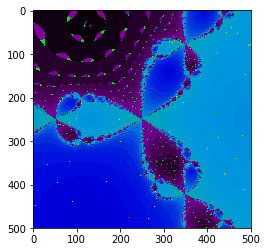

In [140]:
# Uses matplotlib cmap
def grid_to_image_2(grid_root, grid_iter, roots, cmap):
    idxs = np.linspace(0,255,len(roots),dtype=int)
    img = np.zeros((*grid_root.shape,3))
    
    grid_iter = np.log(grid_iter)
    scaled = grid_iter/np.max(grid_iter)
    
    for i in range(len(roots)):
        color = cmap(idxs[i])
        for j in range(3):
            img[grid_root==(i+1),j] = color[j]
    
    img = img*scaled[...,np.newaxis]
    return img

def grid_to_image(grid_root, grid_iter, roots):
    img = np.zeros((grid_root.shape))
    idxs = np.linspace(0,255,len(roots),dtype=int)
    
#     grid_iter = np.log(grid_iter)
    scaled = grid_iter/np.max(grid_iter)
    
    shift = scaled*(256/4)
    
    for i in range(len(roots)):
        img[grid_root==i+1] = idxs[i]+shift[grid_root==i+1]
#         img[grid_root==i+1] = idxs[i]
    
    return img
    

cmap = plt.get_cmap("nipy_spectral")
image = grid_to_image(grid_root,grid_iter,roots)
plt.imshow(image, cmap=cmap)

In [145]:
import matplotlib.animation as animation
# Save video
def save_video(frames, filename, cmap, display=True):
    fig = plt.figure()
    ims = []
    for i in range(len(frames)):
        im = plt.imshow(frames[i], cmap=cmap, animated=True)
        ims.append([im])
        
    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True)
    if display:
        plt.show()
    ani.save(filename)

In [148]:
for idx, image in enumerate(images):
    plt.imsave('%d.jpg' % idx, image, cmap=cmap)

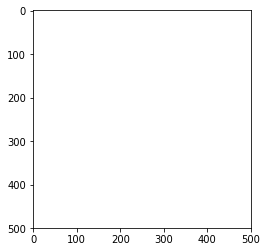

MovieWriter ffmpeg unavailable.


ValueError: unknown file extension: .mp4

In [146]:
save_video(images, 'fractals_are_cool.mp4', cmap)

In [141]:
size = (500,500)
area = ((-1,1), (-1,1))
e = 1e-3
max_iters = 40
alpha = 1

x = Variable('x')
f = x**3 - 1

images = []
for alpha in np.linspace(0.5,1.5,30):
    print(alpha)
    grid_root, grid_iter, roots = fractal_grid(f, size, area, e, max_iters, alpha)
    images.append(grid_to_image(grid_root,grid_iter,roots))

0.5
0.5344827586206896
0.5689655172413793
0.603448275862069
0.6379310344827587
0.6724137931034483
0.7068965517241379
0.7413793103448276
0.7758620689655172
0.8103448275862069
0.8448275862068966
0.8793103448275862
0.9137931034482758
0.9482758620689655
0.9827586206896551
1.0172413793103448
1.0517241379310345
1.0862068965517242
1.1206896551724137
1.1551724137931034
1.1896551724137931
1.2241379310344827
1.2586206896551724
1.293103448275862
1.3275862068965516
1.3620689655172413
1.396551724137931
1.4310344827586206
1.4655172413793103
1.5


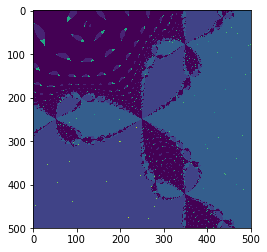

In [12]:
cmap = plt.get_cmap("nipy_spectral")
save_video(images, "test.mp4", cmapw)

In [130]:
import autodiff as AD
from PIL import Image

x_min, x_max = -1.0, 1.0

y_min, y_max = -1.0, 1.0

colors = [\
(180, 0, 30), (0, 180, 30), (0, 30, 180), \
(0, 190, 180), (180, 0, 175), (180, 255, 0), \
(155, 170, 180), (70, 50, 0), (255, 255, 255)]

max_iters = 50
epsilon = 1e-3

def newtons_method(f, z):
   # Fourty iterations for safe measure
    for i in range(max_iters):
        f(x=z)
        zplus = z - f.value()/f.derivative()["x"]
        # Checks for convergence
        if abs(zplus - z) < e:
            return z
        z = zplus

    return None

# Draws the functions
def draw(f, fmg, size, img_name):
    roots = []
    for y in range(size):
        z_y = y * (y_max - y_min)/(size - 1) + y_min
        for x in range(size):
            z_x = x * (x_max - x_min)/(size - 1) + x_min
            root = newtons_method(f, complex(z_x, z_y))
            if root:
                flag = False
                for test_root in roots:
                    if abs(test_root - root) < 10e-3:
                        root = test_root
                        flag = True
                        break
                if not flag:
                    roots.append(root)
            if root:
                img.putpixel((x, y), colors[roots.index(root)])
    print(roots)
    img.save(img_name, "PNG")
 
size = 256
img = Image.new("RGB", (size, size), (255, 255, 255))
x = AD.Variable("x")
draw(x**3 - 1, img, size, "fig1.png");
draw(x**2 - 2*x + 2, img, size, "fig2.png");
draw(x**6 - x**3 + 2, img, size, "fig3.png");
draw(x**3 - 2*x + 2, img, size, "fig3.png");
draw(x**5 - x, img, size, "fig4.png")

[(-0.49932999564375125-0.8662691717880057j), (-0.49943874079775835+0.8655155880346705j), (1.0000024849778555+3.194137909611123e-06j)]
[(1-1.0000305180437934j), (0.9999999410155761+1.0000052510611772j)]
[(-0.8974678109383255-0.674043686347196j), (-0.13512211601345125+1.1145046841860964j), (-0.1342398203185315-1.114421910659587j), (1.032109687382033+0.43998701666231743j), (-0.8975916548458365+0.6739829938752688j), (1.032069500772994-0.4412298156218523j)]
[(0.8846426429094298+0.5897366340732563j), (-1.769309070914845-2.1882337446259715e-05j), (0.8844239850918153-0.5896716501139209j)]
[(-2.6826988092781834e-08-2.6826988092781834e-08j), (0.9999928838587894+3.4396441436271557e-06j), (-2.1956540705781423e-05-0.9998762527357286j), (-0.9998095236426687+7.095189597478013e-05j), (-4.041146215730349e-05+1.0000012535578955j)]


1


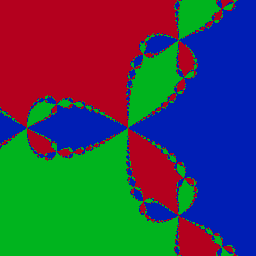

2


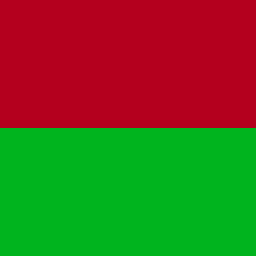

3


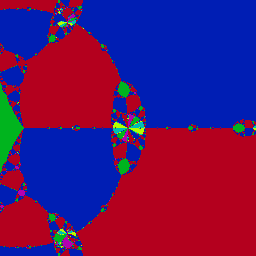

4


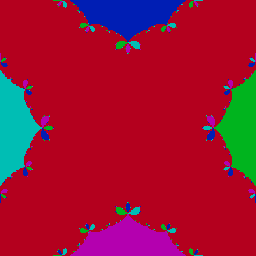

In [131]:
for i in range(1,5):
    print(i)
    display(Image.open(f'fig{i}.png'))